In [1]:
import numpy as np

import matplotlib.pyplot as plt

import cv2
from sklearn import metrics
from google.colab.patches import cv2_imshow
from tqdm import tqdm
import threading as th
import math

In [2]:
!lscpu

Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              2
On-line CPU(s) list: 0,1
Thread(s) per core:  2
Core(s) per socket:  1
Socket(s):           1
NUMA node(s):        1
Vendor ID:           GenuineIntel
CPU family:          6
Model:               79
Model name:          Intel(R) Xeon(R) CPU @ 2.20GHz
Stepping:            0
CPU MHz:             2200.210
BogoMIPS:            4400.42
Hypervisor vendor:   KVM
Virtualization type: full
L1d cache:           32K
L1i cache:           32K
L2 cache:            256K
L3 cache:            56320K
NUMA node0 CPU(s):   0,1
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_sin

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
img = cv2.imread('/content/drive/MyDrive/mona.jpg')

In [6]:
(img).shape

(240, 161, 3)

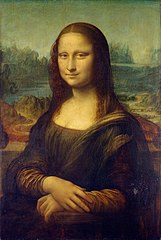

In [7]:
cv2_imshow(img)

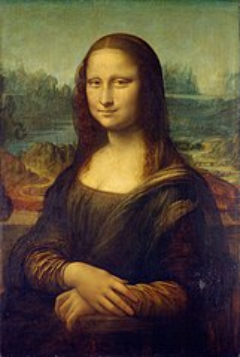

In [9]:
resize_to=240

hw_ratio=img.shape[0]/img.shape[1]
target_img=cv2.resize(img, (resize_to, int(hw_ratio*resize_to))) # widtxXheight
# target_img=np.asarray(target_img)/255
cv2_imshow(target_img)

In [10]:
def random_circle():
    '''Function generating random circles.
    Cirlce is presented as a numpy array lenght 7 in such scheme
    [x, y, radius, opacity, r, g, b]

    Returns:
        circle (numpy array length 7): the generated circle
    '''
    return np.random.random(7)


In [11]:
def random_individual(chromosome_length, genotype=7):
    '''Function generating random individual.
    Args:
        chromosome_length (int): number of figures in an individual
        genotype (int): lenght of a gene (defaults 7 for circle)
    Returns:
        indiv (numpy array shaped (chromosome_length, genotype)): the generated individual
    '''
    indiv = np.zeros((chromosome_length, genotype))
    if genotype == 7:
        for i in range(chromosome_length):
            indiv[i] = random_circle()
    
    return indiv

In [12]:
def random_population(population_size, chromosome_length, genotype=7):
    '''Function generating random population.
    Args:
        population_size (int): number of individuals in the population
        chromosome_length (int): number of figures in and individual
        genotype (int): length of a gene (defaults 7 for circle)
    
    Returns:
        population: generated population
    '''
    population = np.zeros((population_size, chromosome_length, genotype))
    for i in range(population_size):
        population[i] = random_individual(chromosome_length, genotype)
    
    return population

In [13]:
def draw_circle(dst, gene):
    '''Function drawing circle from given genotype on given image.
    Args:
        dst: destination image
        gene: circle encoded as a single gene
    '''
    height, width = dst.shape[0], dst.shape[1]
    avg_radius = math.sqrt(height**2 + width**2)

    y = int(gene[1] * height)
    x = int(gene[0] * width)

    radius = int(gene[2] * avg_radius)
    color = (gene[4:7] * 255).astype(int).tolist()

    cv2.circle(dst, center=(y, x), radius=radius, color=color, thickness=-1)

In [14]:
def draw(dst, gene, figure="Cirlce"):
    '''Function drawing the given figure from given gene on dst image.
    Args:
        dst: destination image to draw the figure on
        gene: the single figure encoded as gene
        figure: string with figure type
    '''
    # drawing circles
    if figure == "Circle":
        draw_circle(dst, gene)

    # place for other figures

In [15]:
def get_population_phenotypes(population, width, height, figure="Circle"):
    '''Function transforming each individual in he population into phenotype.
    Args:
        population: current population
        width: width of the target img
        height: height of the target img
    Returns:
        phenotypes: an array with phenotypes of each individual in the population
    '''
    phenotypes = np.zeros((population.shape[0], height, width, 3))
    for i in range(population.shape[0]):
        phenotypes[i] = get_phenotype(population[i], width, height, figure=figure)
    
    return phenotypes

In [21]:
def get_phenotype(genotype, width, height, figure="Circle"):
    '''Function getting phenotype out of an individual.
    Args:
        genotype: single individual from the population (his genotype)
        width: width of the target image
        height: height of the target image
        figure: string with figure type in single genotype
    Returns:
        phenotype: phenotype of the given individual
    '''
    phenotype = np.zeros((height, width, 3))
    for gene in genotype:
        overlay = phenotype.copy()
        draw(overlay, gene, figure=figure)
        opacity = gene[-4]

        phenotype = cv2.addWeighted(overlay, opacity, phenotype, 1-opacity, 0)
    return phenotype

In [28]:
def get_phenotypes_threading(phenotypes, index, genotype, width, height, figure="Circle"):
    phenotypes[index] = get_phenotype(genotype, width, height, figure)

In [17]:
def MSE(phenotypes, target):
    return np.sum(np.square(phenotypes-target), axis=(1,2,3)) / (target.shape[0]*target.shape[1])

In [18]:
pop = random_population(100, 100)

In [19]:
img.shape

(240, 161, 3)

In [22]:
phens = get_population_phenotypes(pop, 161, 240)

In [24]:
mse = MSE(phens, img)
mse

array([32402.3409871 , 18290.82507526, 14539.31173929, 16938.50855026,
       13181.89336211, 26430.78385968, 34753.90696419, 19213.58811394,
        6866.68206858, 20200.81393503, 21502.08185235, 13707.05195934,
       27853.86862519, 22910.05669158, 38940.13587472, 20012.9200442 ,
       31130.1509308 , 27141.6185418 , 16941.10542918, 25293.69487076,
       56807.86496119, 31972.77125023, 20593.04698459, 22555.53339474,
       30009.50732935, 34252.69418509, 24525.98502185, 17428.63459431,
       29348.01592541, 10590.48389779, 21380.26898676, 19619.95450356,
       17348.28986204, 10346.3112801 , 30374.99473951, 55970.79318107,
       17664.64062279, 23775.65801234, 13315.95333472, 16286.5237076 ,
       12375.06636788, 20889.03062041, 13180.8448548 , 31989.9553532 ,
       28206.79770319, 22421.59258242, 15894.45465177, 20726.96707737,
       32640.46662425, 33295.16324016, 32094.47270746, 25399.00076232,
        8677.83692161, 22326.56533353, 29193.68481555, 35197.91106674,
      

6866.682068579859


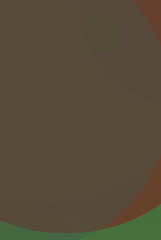

In [25]:
ar = np.argmin(mse)
print(mse[ar])
cv2_imshow(phens[ar])

In [26]:
def mutate_population(population, width, height, sigma=0.1666, mut_prob=0.3):
    mutation_indices = (np.random.random(population.shape) < mut_prob).astype(float)
    population += mutation_indices * np.random.randn(*population.shape) * sigma
    population[:, :, 2:7] = np.clip(population[:, :, 2:7], [0], [1])
    return population

In [27]:
def show_img(img):
    cv2_imshow(img)

# ES

In [43]:
def es(objective_func, chrom_length, pop_size, iters, num_offspring, num_parents, sigma, target_img, parallel=True):
    best_solution = np.empty((1, chrom_length, 7))
    best_solution_objective_value = np.inf

    log_objective_values = np.empty((number_of_iterations, 4))
    log_best_solutions = np.empty((int(number_of_iterations/1000), chromosome_length, 7))
    
    height, width = target_img.shape[0], target_img.shape[1]
    
    #generating random population
    current_population = random_population(pop_size, chromosome_length)
    indiv_shape = current_population.shape[1:]

    # evaluating the objective population on the current population
    current_population_phenotypes = np.empty((pop_size, height, width, 3))
    if parallel:        
        threads=[]
        for i in range(pop_size):
            t=th.Thread(target=get_phenotypes_threading, args=[current_population_phenotypes, i,
                                                            current_population[i], width, height])
            t.start()
            threads.append(t)
        for t in threads:
            t.join()
    else:
        current_population_phenotypes = get_population_phenotypes(current_population, width, height)
    current_population_objective_values = objective_func(current_population_phenotypes, target_img)

    for iteration in tqdm(range(iters)):
        # selecting the parent indices by the roulette wheel method
        fitness_values = current_population_objective_values - current_population_objective_values.min()
        if fitness_values.sum() > 0:
            fitness_values = fitness_values / fitness_values.sum()
        else:
            fitness_values = 1.0 / pop_size * np.ones(pop_size)
        parent_indices = np.random.choice(pop_size, (num_offspring, num_parents), True, fitness_values).astype(np.int64)
    
        # creating the children population by Global Intermediere Recombination
        children_population = np.zeros((num_offspring, *indiv_shape))
        for i in range(num_offspring):
            children_population[i, :] = current_population[parent_indices[i, :], :].mean(axis=0)
        
        # mutating the children population
        children_population = mutate_population(children_population, width, height)

        # evaluating the objective function on the children population
        children_population_phenotypes = np.empty((num_offspring, height, width, 3))
        if parallel:
            hreads=[]
            for i in range(num_offspring):
                t=th.Thread(target=get_phenotypes_threading, args=[children_population_phenotypes, i,
                                                            children_population[i], width, height])
                t.start()
                threads.append(t)
            for t in threads:
                t.join()
        else:
            children_population_phenotypes = get_population_phenotypes(children_population, width, height)
        children_population_objective_values = objective_function(children_population_phenotypes, target_img)

        # replacing the current population by (Mu + Lambda) Replacement
        current_population_objective_values = np.hstack([current_population_objective_values, children_population_objective_values])
        current_population = np.vstack([current_population, children_population])
        current_population_phenotypes = np.vstack([current_population_phenotypes, children_population_phenotypes])

        I = np.argsort(current_population_objective_values)
        current_population = current_population[I[:pop_size], :]
        current_population_phenotypes = current_population_phenotypes[I[:pop_size], :]
        current_population_objective_values = current_population_objective_values[I[:pop_size]]

     # recording some statistics
        if best_solution_objective_value > current_population_objective_values[0]:
            best_solution = current_population[0, :]
            best_solution_objective_value = current_population_objective_values[0]

        log_objective_values[iteration, :] = [current_population_objective_values.min(), current_population_objective_values.max(), current_population_objective_values.mean(), current_population_objective_values.std()]

        if np.mod(iteration, 1000) == 0:
            print("Iteration %04d : best score = %0.8f, mean score = %0.8f." % (iteration, log_objective_values[:iteration+1, 0], log_objective_values[iteration, 2]))
            log_best_solutions[iteration, :] = current_population[0, :]
            show_img(current_population_phenotypes[0])

    return best_solution_objective_value, best_solution, log_objective_values, log_best_solutions

In [44]:
chromosome_length = 150
population_size = 10
number_of_iterations = 50000
number_of_offspring = 100
number_of_parents = 2
sigma = 1/6
objective_function = MSE

  0%|          | 0/50000 [00:00<?, ?it/s]

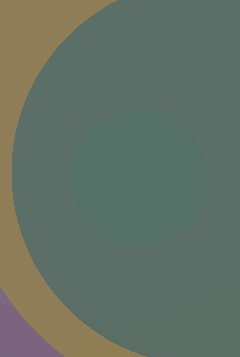

  0%|          | 1/50000 [00:14<202:58:51, 14.61s/it]

Iteration 0000 : best score = 11114.13675196, mean score = 14132.40400175.


  0%|          | 1/50000 [00:24<336:35:20, 24.23s/it]


KeyboardInterrupt: ignored

In [46]:
#objective_func, chrom_length, pop_size, iters, num_offspring, num_parents, sigma, target_img
val, solution, log_vals, log_sols = es(MSE, chromosome_length, population_size, number_of_iterations, number_of_offspring, number_of_parents, sigma, target_img, False)

In [ ]:
def es(objective_function, population_size, number_of_iterations, number_of_offspring, number_of_parents, sigma, tau, tau_0, log_frequency=1):

    best_solution = np.empty((1, chromosome_length))
    best_solution_objective_value = 0.00

    log_objective_values = np.empty((number_of_iterations, 4))
    log_best_solutions = np.empty((number_of_iterations, chromosome_length))
    log_best_sigmas = np.empty((number_of_iterations, chromosome_length))

    # generating an initial population
    current_population_solutions = 100.0 * np.random.rand(population_size, chromosome_length)
    current_population_sigmas = sigma * np.ones((population_size, chromosome_length))

    # evaluating the objective function on the current population
    current_population_objective_values = objective_function(current_population_solutions)

    for t in range(number_of_iterations):

        # selecting the parent indices by the roulette wheel method
        fitness_values = current_population_objective_values - current_population_objective_values.min()
        if fitness_values.sum() > 0:
            fitness_values = fitness_values / fitness_values.sum()
        else:
            fitness_values = 1.0 / population_size * np.ones(population_size)
        parent_indices = np.random.choice(population_size, (number_of_offspring, number_of_parents), True, fitness_values).astype(np.int64)

        # creating the children population by Global Intermediere Recombination
        children_population_solutions = np.zeros((number_of_offspring, chromosome_length))
        children_population_sigmas = np.zeros((number_of_offspring, chromosome_length))
        for i in range(number_of_offspring):
            children_population_solutions[i, :] = current_population_solutions[parent_indices[i, :], :].mean(axis=0)
            children_population_sigmas[i, :] = current_population_sigmas[parent_indices[i, :], :].mean(axis=0)

        # mutating the children population by adding random gaussian noise
        children_population_sigmas = children_population_sigmas * np.exp(tau * np.random.randn(number_of_offspring, chromosome_length) + tau_0 * np.random.randn(number_of_offspring, 1))
        children_population_solutions = children_population_solutions + children_population_sigmas * np.random.randn(number_of_offspring, chromosome_length)

        # evaluating the objective function on the children population
        children_population_objective_values = objective_function(children_population_solutions)

        # replacing the current population by (Mu + Lambda) Replacement
        current_population_objective_values = np.hstack([current_population_objective_values, children_population_objective_values])
        current_population_solutions = np.vstack([current_population_solutions, children_population_solutions])
        current_population_sigmas = np.vstack([current_population_sigmas, children_population_sigmas])

        I = np.argsort(current_population_objective_values)[::-1]
        current_population_solutions = current_population_solutions[I[:population_size], :]
        current_population_sigmas = current_population_sigmas[I[:population_size], :]
        current_population_objective_values = current_population_objective_values[I[:population_size]]

        # recording some statistics
        if best_solution_objective_value < current_population_objective_values[0]:
            best_solution = current_population_solutions[0, :]
            best_solution_objective_value = current_population_objective_values[0]
        log_objective_values[t, :] = [current_population_objective_values.min(), current_population_objective_values.max(), current_population_objective_values.mean(), current_population_objective_values.std()]
        log_best_solutions[t, :] = current_population_solutions[0, :]
        log_best_sigmas[t, :] = current_population_sigmas[0, :]

        if np.mod(t, log_frequency) == 0:
            print("Iteration %04d : best score = %0.8f, mean score = %0.8f." % (t, log_objective_values[:t+1, 1].max(), log_objective_values[t, 2]))

    return best_solution_objective_value, best_solution, log_objective_values, log_best_solutions, log_best_sigmas